# Hidden Markov Model Classification Filter Demo

This notebook demonstrates how a Hidden Markov Model (HMM) based filter can improve noisy classifier outputs over time. The filter exploits temporal consistency - if something was class X a moment ago, it's likely still class X now.

## Key Features
- **Asymmetric confusion matrices**: Real classifiers often have asymmetric error patterns where P(A→B) ≠ P(B→A)
- **Different per-class accuracies**: Some classes are easier to classify than others
- **Attractor classes**: Some classes act as "attractors" that other classes get confused with

## Overview
1. Define the ClassificationFilter class
2. Generate ground truth sequences
3. Define asymmetric confusion matrices (low, medium, high error)
4. Visualize the confusion matrix patterns
5. Generate noisy sequences and apply the filter
6. Analyze the effect of different stickiness values
7. Compare metrics before and after filtering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import pandas as pd

np.random.seed(42)  # For reproducibility

## 1. Classification Filter Class

This HMM-based filter uses:
- **Emission model**: P(observation | true_class) - the confusion matrix
- **Transition model**: P(next_class | current_class) - controlled by stickiness
- **Belief state**: Current probability distribution over classes

In [2]:
class ClassificationFilter:
    def __init__(self, n_classes, confusion_matrix=None, stickiness=0.9):
        """
        Filter noisy classifier outputs over time.

        Args:
            n_classes: Number of possible classes
            confusion_matrix: P(predicted | true), shape (n_classes, n_classes)
                              Row = true class, Col = predicted class
                              If None, assumes diagonal + uniform noise
            stickiness: P(class stays the same) — higher means slower transitions
        """
        self.n_classes = n_classes

        # Observation model: P(observation | true_class)
        if confusion_matrix is not None:
            self.emission = confusion_matrix
        else:
            # Default: 80% correct, 20% spread among others
            accuracy = 0.8
            self.emission = np.full((n_classes, n_classes), (1 - accuracy) / (n_classes - 1))
            np.fill_diagonal(self.emission, accuracy)

        # Transition model: P(next_class | current_class)
        # Sticky — tend to stay in same class
        self.transition = np.full((n_classes, n_classes), (1 - stickiness) / (n_classes - 1))
        np.fill_diagonal(self.transition, stickiness)

        # Belief state: P(true_class = k)
        self.belief = np.ones(n_classes) / n_classes

    def reset(self):
        """Reset belief to uniform distribution."""
        self.belief = np.ones(self.n_classes) / self.n_classes

    def update(self, observation):
        """
        Update belief with new classifier output.
        Returns MAP estimate of true class.
        """
        # Predict: propagate belief through transition model
        predicted_belief = self.transition.T @ self.belief

        # Update: incorporate observation likelihood
        likelihood = self.emission[:, observation]  # P(obs | each true class)
        posterior = predicted_belief * likelihood
        posterior /= posterior.sum()

        self.belief = posterior
        return np.argmax(posterior), posterior

    def filter_sequence(self, observations):
        """Filter a sequence of classifier outputs."""
        self.reset()
        estimates = []
        for obs in observations:
            est, _ = self.update(obs)
            estimates.append(est)
        return np.array(estimates)

## 2. Generate Ground Truth Sequence

The ground truth sequence follows the pattern:
- 50 points of class 0
- 50 points of class 1
- 50 points of class 0
- 50 points of class 2
- 50 points of class 0
- 50 points of class 3
- 50 points of class 0

In [3]:
def generate_ground_truth():
    """Generate the ground truth sequence."""
    sequence = []
    pattern = [0, 1, 0, 2, 0, 3, 0]
    for class_label in pattern:
        sequence.extend([class_label] * 50)
    return np.array(sequence)

ground_truth = generate_ground_truth()
n_classes = 4

print(f"Total sequence length: {len(ground_truth)}")
print(f"Number of classes: {n_classes}")
print(f"Class distribution: {np.bincount(ground_truth)}")

Total sequence length: 350
Number of classes: 4
Class distribution: [200  50  50  50]


## 3. Define Asymmetric Confusion Matrices

We'll create three **asymmetric** confusion matrices where:
- Different classes have different error rates
- Misclassifications are not symmetric (e.g., class 0→1 errors differ from 1→0 errors)
- Some classes are "attractors" that others get confused with more often

Error levels:
- **Low error**: 90-98% accuracy per class
- **Medium error**: 70-90% accuracy per class
- **High error**: 50-75% accuracy per class

In [4]:
def create_asymmetric_confusion_matrix(error_level):
    """
    Create asymmetric confusion matrices with realistic error patterns.

    Each row must sum to 1.0 (valid probability distribution).
    Row i, Col j = P(predict j | true class is i)
    """

    if error_level == 'low':
        # Low error: 90-98% accuracy, minor asymmetric confusions
        # Class 0 (baseline): very reliable, occasionally confused with 1
        # Class 1: good accuracy, sometimes confused with 0
        # Class 2: excellent accuracy, rarely confused
        # Class 3: good accuracy, occasionally confused with 2
        cm = np.array([
            [0.95, 0.04, 0.005, 0.005],  # Class 0: mostly correct, some → 1
            [0.06, 0.92, 0.01, 0.01],     # Class 1: some → 0
            [0.01, 0.01, 0.97, 0.01],     # Class 2: very accurate
            [0.01, 0.02, 0.05, 0.92],     # Class 3: some → 2
        ])

    elif error_level == 'medium':
        # Medium error: 70-90% accuracy, notable asymmetric patterns
        # Class 0: often confused with 1 (neighboring class)
        # Class 1: strong attractor - other classes get confused as 1
        # Class 2: moderate accuracy, confused with 1 and 3
        # Class 3: often confused with 2
        cm = np.array([
            [0.82, 0.12, 0.04, 0.02],     # Class 0: notable confusion → 1
            [0.05, 0.88, 0.04, 0.03],     # Class 1: relatively stable
            [0.05, 0.15, 0.72, 0.08],     # Class 2: often → 1, some → 3
            [0.03, 0.07, 0.15, 0.75],     # Class 3: often → 2
        ])

    elif error_level == 'high':
        # High error: 50-75% accuracy, strong asymmetric confusions
        # Class 0: frequently confused with 1
        # Class 1: strong attractor - many things look like class 1
        # Class 2: poor accuracy, confused with 1 and 3
        # Class 3: moderate accuracy but confused with 2 and 1
        cm = np.array([
            [0.65, 0.25, 0.07, 0.03],     # Class 0: heavy confusion → 1
            [0.08, 0.75, 0.10, 0.07],     # Class 1: best accuracy (attractor)
            [0.10, 0.25, 0.50, 0.15],     # Class 2: worst accuracy, → 1 common
            [0.05, 0.15, 0.20, 0.60],     # Class 3: confused with 2 and 1
        ])

    # Verify rows sum to 1
    assert np.allclose(cm.sum(axis=1), 1.0), "Rows must sum to 1"
    return cm

# Define error levels
error_levels = {
    'low': {'color': 'green'},
    'medium': {'color': 'orange'},
    'high': {'color': 'red'}
}

confusion_matrices = {}
for name in error_levels.keys():
    confusion_matrices[name] = create_asymmetric_confusion_matrix(name)
    cm = confusion_matrices[name]
    diag_acc = np.diag(cm)
    print(f"\n{name.upper()} ERROR - Asymmetric Confusion Matrix:")
    print(f"Per-class accuracy: {diag_acc.round(2)}")
    print(f"Mean accuracy: {diag_acc.mean():.2f}")
    print()

    # Display with class labels
    print("          Predicted")
    print("True    C0    C1    C2    C3")
    for i in range(4):
        row = "  ".join([f"{cm[i,j]:.2f}" for j in range(4)])
        print(f" C{i}   {row}")


LOW ERROR - Asymmetric Confusion Matrix:
Per-class accuracy: [0.95 0.92 0.97 0.92]
Mean accuracy: 0.94

          Predicted
True    C0    C1    C2    C3
 C0   0.95  0.04  0.01  0.01
 C1   0.06  0.92  0.01  0.01
 C2   0.01  0.01  0.97  0.01
 C3   0.01  0.02  0.05  0.92

MEDIUM ERROR - Asymmetric Confusion Matrix:
Per-class accuracy: [0.82 0.88 0.72 0.75]
Mean accuracy: 0.79

          Predicted
True    C0    C1    C2    C3
 C0   0.82  0.12  0.04  0.02
 C1   0.05  0.88  0.04  0.03
 C2   0.05  0.15  0.72  0.08
 C3   0.03  0.07  0.15  0.75

HIGH ERROR - Asymmetric Confusion Matrix:
Per-class accuracy: [0.65 0.75 0.5  0.6 ]
Mean accuracy: 0.62

          Predicted
True    C0    C1    C2    C3
 C0   0.65  0.25  0.07  0.03
 C1   0.08  0.75  0.10  0.07
 C2   0.10  0.25  0.50  0.15
 C3   0.05  0.15  0.20  0.60


## 4. Visualize the Asymmetric Confusion Matrices

Let's visualize the classifier confusion matrices to see the asymmetric error patterns.


Key asymmetric patterns:
- Class 1 is an 'attractor': other classes are often misclassified as Class 1
- Class 0 → Class 1 confusion is much higher than Class 1 → Class 0
- Class 2 has the lowest accuracy in high-error case (50%)
- Class 3 is often confused with Class 2 (neighboring effect)


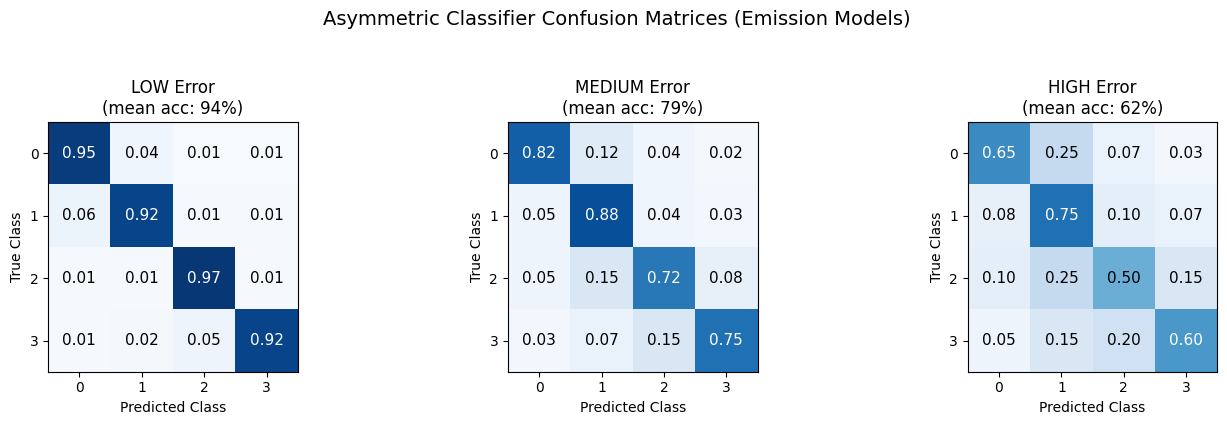

In [5]:
# Visualize the asymmetric confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, (name, cm) in enumerate(confusion_matrices.items()):
    ax = axes[idx]
    im = ax.imshow(cm, cmap='Blues', vmin=0, vmax=1)

    # Add text annotations
    for i in range(n_classes):
        for j in range(n_classes):
            color = 'white' if cm[i, j] > 0.5 else 'black'
            ax.text(j, i, f'{cm[i, j]:.2f}', ha='center', va='center',
                    fontsize=11, color=color)

    ax.set_title(f'{name.upper()} Error\n(mean acc: {np.diag(cm).mean():.0%})')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_xticks(range(n_classes))
    ax.set_yticks(range(n_classes))

plt.suptitle('Asymmetric Classifier Confusion Matrices (Emission Models)', fontsize=14, y=1.05)
plt.tight_layout()

print("\nKey asymmetric patterns:")
print("- Class 1 is an 'attractor': other classes are often misclassified as Class 1")
print("- Class 0 → Class 1 confusion is much higher than Class 1 → Class 0")
print("- Class 2 has the lowest accuracy in high-error case (50%)")
print("- Class 3 is often confused with Class 2 (neighboring effect)")

## 5. Generate Noisy Sequences

Using each asymmetric confusion matrix, we'll generate noisy observations from the ground truth.

In [6]:
def generate_noisy_sequence(ground_truth, confusion_matrix):
    """
    Generate noisy observations using the confusion matrix.

    For each true class, sample from P(observation | true_class).
    """
    n_classes = confusion_matrix.shape[0]
    noisy = np.zeros_like(ground_truth)

    for i, true_class in enumerate(ground_truth):
        # Sample from the row of confusion matrix corresponding to true class
        noisy[i] = np.random.choice(n_classes, p=confusion_matrix[true_class])

    return noisy

# Generate noisy sequences for each error level
noisy_sequences = {}
for name, cm in confusion_matrices.items():
    noisy_sequences[name] = generate_noisy_sequence(ground_truth, cm)
    raw_accuracy = accuracy_score(ground_truth, noisy_sequences[name])

    # Show per-class accuracy in the noisy sequence
    print(f"\n{name.upper()} error - Overall raw accuracy: {raw_accuracy:.3f}")
    for cls in range(n_classes):
        mask = ground_truth == cls
        if mask.sum() > 0:
            cls_acc = (noisy_sequences[name][mask] == cls).mean()
            print(f"  Class {cls}: {cls_acc:.3f} (expected: {cm[cls, cls]:.2f})")


LOW error - Overall raw accuracy: 0.943
  Class 0: 0.940 (expected: 0.95)
  Class 1: 0.920 (expected: 0.92)
  Class 2: 0.980 (expected: 0.97)
  Class 3: 0.940 (expected: 0.92)

MEDIUM error - Overall raw accuracy: 0.789
  Class 0: 0.815 (expected: 0.82)
  Class 1: 0.880 (expected: 0.88)
  Class 2: 0.700 (expected: 0.72)
  Class 3: 0.680 (expected: 0.75)

HIGH error - Overall raw accuracy: 0.620
  Class 0: 0.645 (expected: 0.65)
  Class 1: 0.780 (expected: 0.75)
  Class 2: 0.420 (expected: 0.50)
  Class 3: 0.560 (expected: 0.60)


## 6. Apply Classification Filter

Now we'll filter each noisy sequence using different stickiness values to see how they affect performance.

In [7]:
stickiness_values = [0.7, 0.85, 0.95]

# Store filtered results
filtered_sequences = {}

for error_level, cm in confusion_matrices.items():
    filtered_sequences[error_level] = {}
    noisy = noisy_sequences[error_level]

    for stickiness in stickiness_values:
        cf = ClassificationFilter(n_classes, confusion_matrix=cm, stickiness=stickiness)
        filtered = cf.filter_sequence(noisy)
        filtered_sequences[error_level][stickiness] = filtered

print("Filtering complete for all combinations.")

Filtering complete for all combinations.


## 7. Visualize Sequences

Compare ground truth, noisy observations, and filtered results.

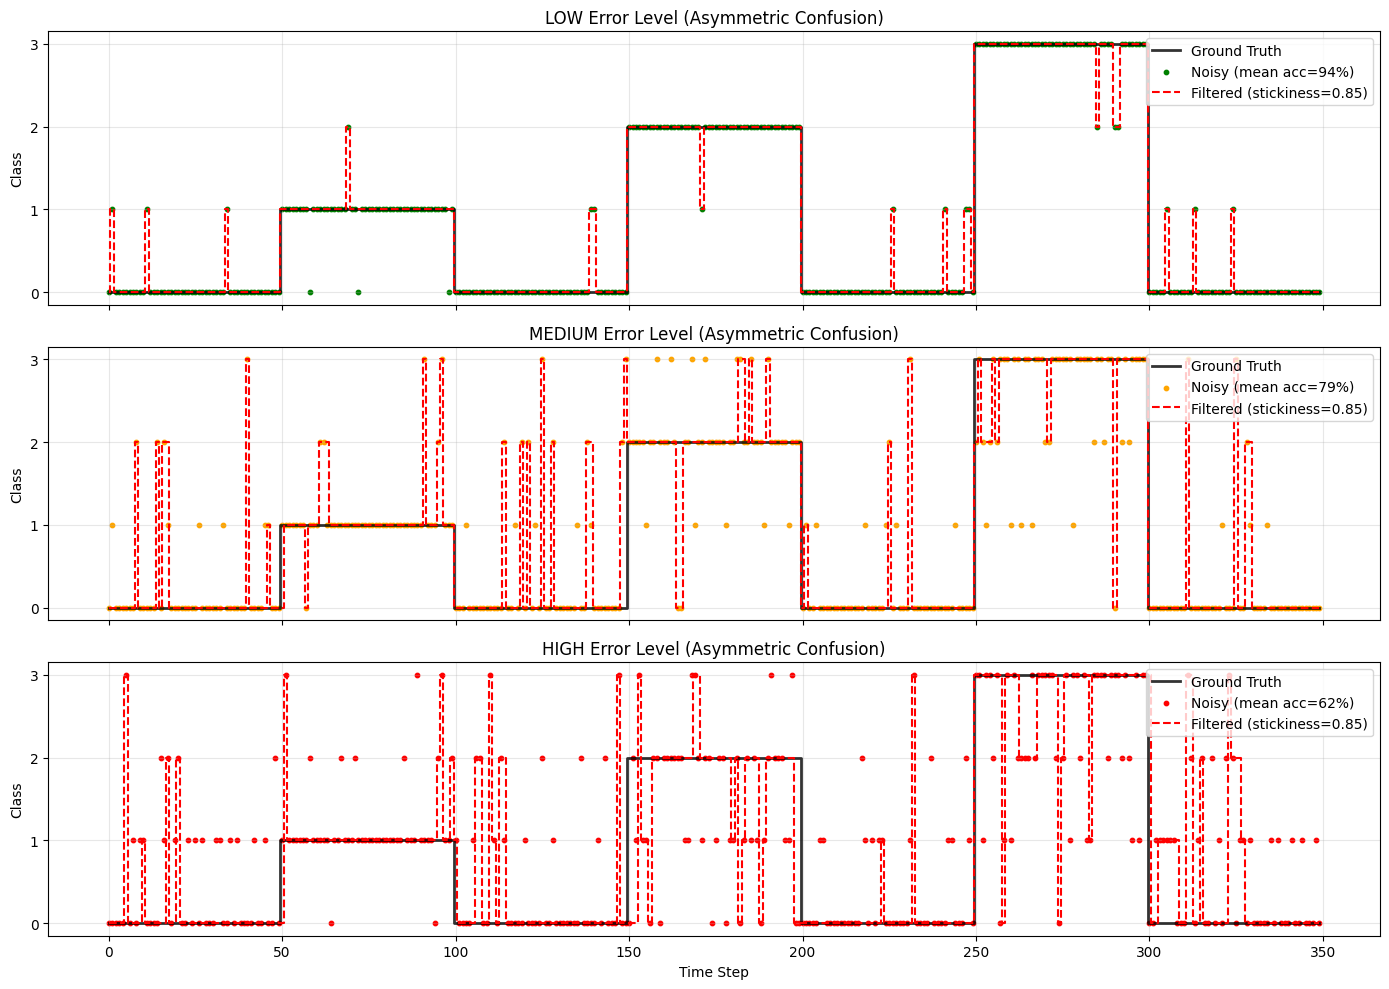

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

time = np.arange(len(ground_truth))

for idx, (error_level, params) in enumerate(error_levels.items()):
    ax = axes[idx]
    color = params['color']
    cm = confusion_matrices[error_level]
    mean_acc = np.diag(cm).mean()

    # Plot ground truth
    ax.step(time, ground_truth, where='mid', label='Ground Truth',
            color='black', linewidth=2, alpha=0.8)

    # Plot noisy sequence
    ax.scatter(time, noisy_sequences[error_level],  s=10,
               color=color, label=f'Noisy (mean acc={mean_acc:.0%})')

    # Plot filtered with best stickiness (0.85)
    filtered = filtered_sequences[error_level][0.85]
    ax.step(time, filtered, where='mid', label='Filtered (stickiness=0.85)',
            color='red', linestyle='--')

    ax.set_ylabel('Class')
    ax.set_title(f'{error_level.upper()} Error Level (Asymmetric Confusion)')
    ax.set_yticks([0, 1, 2, 3])
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time Step')
plt.tight_layout()

## 8. Effect of Stickiness

Compare how different stickiness values affect filtering for the high-error case.

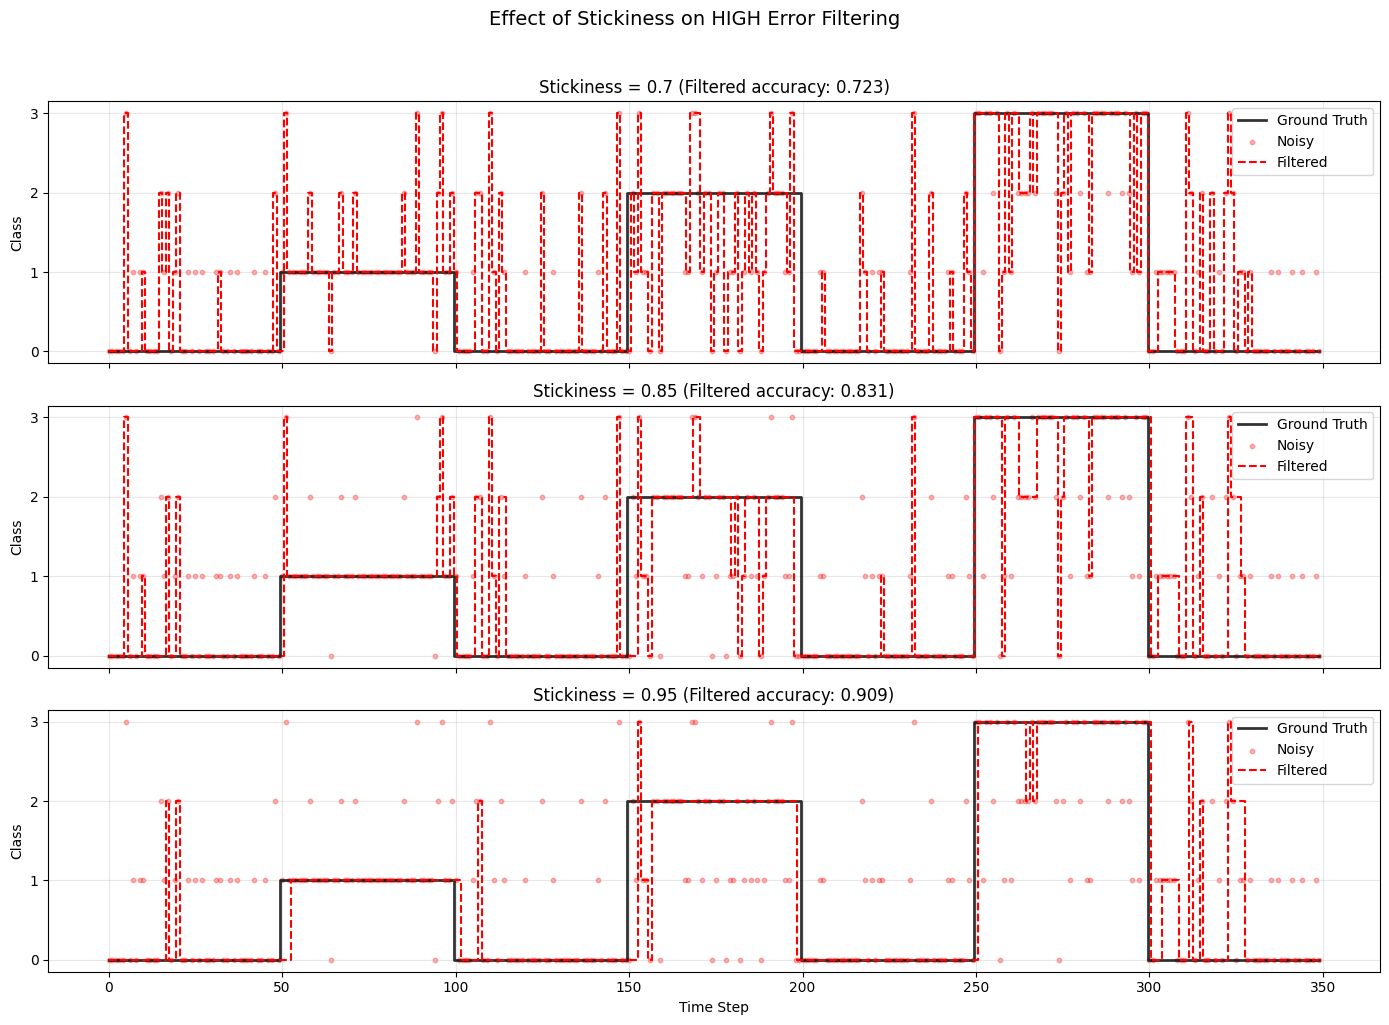

In [9]:
fig, axes = plt.subplots(len(stickiness_values), 1, figsize=(14, 10), sharex=True)

error_level = 'high'  # Focus on high error to see the effect clearly
noisy = noisy_sequences[error_level]

for idx, stickiness in enumerate(stickiness_values):
    ax = axes[idx]
    filtered = filtered_sequences[error_level][stickiness]

    # Plot ground truth
    ax.step(time, ground_truth, where='mid', label='Ground Truth',
            color='black', linewidth=2, alpha=0.8)

    # Plot noisy
    ax.scatter(time, noisy, alpha=0.3, s=10, color='red', label='Noisy')

    # Plot filtered
    ax.step(time, filtered, where='mid', label=f'Filtered',
            color='red', linewidth=1.5, linestyle='--')

    acc = accuracy_score(ground_truth, filtered)
    ax.set_ylabel('Class')
    ax.set_title(f'Stickiness = {stickiness} (Filtered accuracy: {acc:.3f})')
    ax.set_yticks([0, 1, 2, 3])
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time Step')
plt.suptitle('Effect of Stickiness on HIGH Error Filtering', fontsize=14, y=1.02)
plt.tight_layout();

## 9. Comprehensive Metrics Analysis

Compute accuracy, precision, recall, and F1 scores for all combinations.

In [10]:
def compute_metrics(y_true, y_pred):
    """Compute comprehensive metrics."""
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro')
    }

# Collect all results
results = []

for error_level in error_levels.keys():
    noisy = noisy_sequences[error_level]

    # Raw noisy metrics
    raw_metrics = compute_metrics(ground_truth, noisy)
    results.append({
        'Error Level': error_level,
        'Type': 'Raw (Noisy)',
        'Stickiness': '-',
        **raw_metrics
    })

    # Filtered metrics for each stickiness
    for stickiness in stickiness_values:
        filtered = filtered_sequences[error_level][stickiness]
        filtered_metrics = compute_metrics(ground_truth, filtered)
        results.append({
            'Error Level': error_level,
            'Type': 'Filtered',
            'Stickiness': stickiness,
            **filtered_metrics
        })

results_df = pd.DataFrame(results)
results_df = results_df.round(3)
print("\n" + "="*80)
print("COMPREHENSIVE METRICS SUMMARY")
print("="*80 + "\n")
print(results_df.to_string(index=False))


COMPREHENSIVE METRICS SUMMARY

Error Level        Type Stickiness  accuracy  f1_macro  precision_macro  recall_macro
        low Raw (Noisy)          -     0.943     0.932            0.922         0.945
        low    Filtered        0.7     0.943     0.932            0.922         0.945
        low    Filtered       0.85     0.951     0.941            0.929         0.960
        low    Filtered       0.95     0.977     0.970            0.965         0.975
     medium Raw (Noisy)          -     0.789     0.730            0.711         0.769
     medium    Filtered        0.7     0.809     0.762            0.738         0.804
     medium    Filtered       0.85     0.877     0.847            0.839         0.867
     medium    Filtered       0.95     0.946     0.923            0.920         0.928
       high Raw (Noisy)          -     0.620     0.562            0.575         0.601
       high    Filtered        0.7     0.723     0.651            0.639         0.680
       high    Filtere

In [11]:
# Calculate improvement from filtering
print("\n" + "="*80)
print("ACCURACY IMPROVEMENT FROM FILTERING")
print("="*80 + "\n")

improvement_data = []

for error_level in error_levels.keys():
    raw_acc = accuracy_score(ground_truth, noisy_sequences[error_level])

    for stickiness in stickiness_values:
        filtered = filtered_sequences[error_level][stickiness]
        filtered_acc = accuracy_score(ground_truth, filtered)
        improvement = filtered_acc - raw_acc
        pct_improvement = (improvement / (1 - raw_acc)) * 100 if raw_acc < 1 else 0

        improvement_data.append({
            'Error Level': error_level,
            'Stickiness': stickiness,
            'Raw Acc': raw_acc,
            'Filtered Acc': filtered_acc,
            'Improvement': improvement,
            '% Error Reduction': pct_improvement
        })

improvement_df = pd.DataFrame(improvement_data).round(3)
print(improvement_df.to_string(index=False))


ACCURACY IMPROVEMENT FROM FILTERING

Error Level  Stickiness  Raw Acc  Filtered Acc  Improvement  % Error Reduction
        low        0.70    0.943         0.943        0.000              0.000
        low        0.85    0.943         0.951        0.009             15.000
        low        0.95    0.943         0.977        0.034             60.000
     medium        0.70    0.789         0.809        0.020              9.459
     medium        0.85    0.789         0.877        0.089             41.892
     medium        0.95    0.789         0.946        0.157             74.324
       high        0.70    0.620         0.723        0.103             27.068
       high        0.85    0.620         0.831        0.211             55.639
       high        0.95    0.620         0.909        0.289             75.940


## 10. Observed Confusion Matrices Before and After Filtering

Compare the empirical confusion matrices from the noisy and filtered sequences.

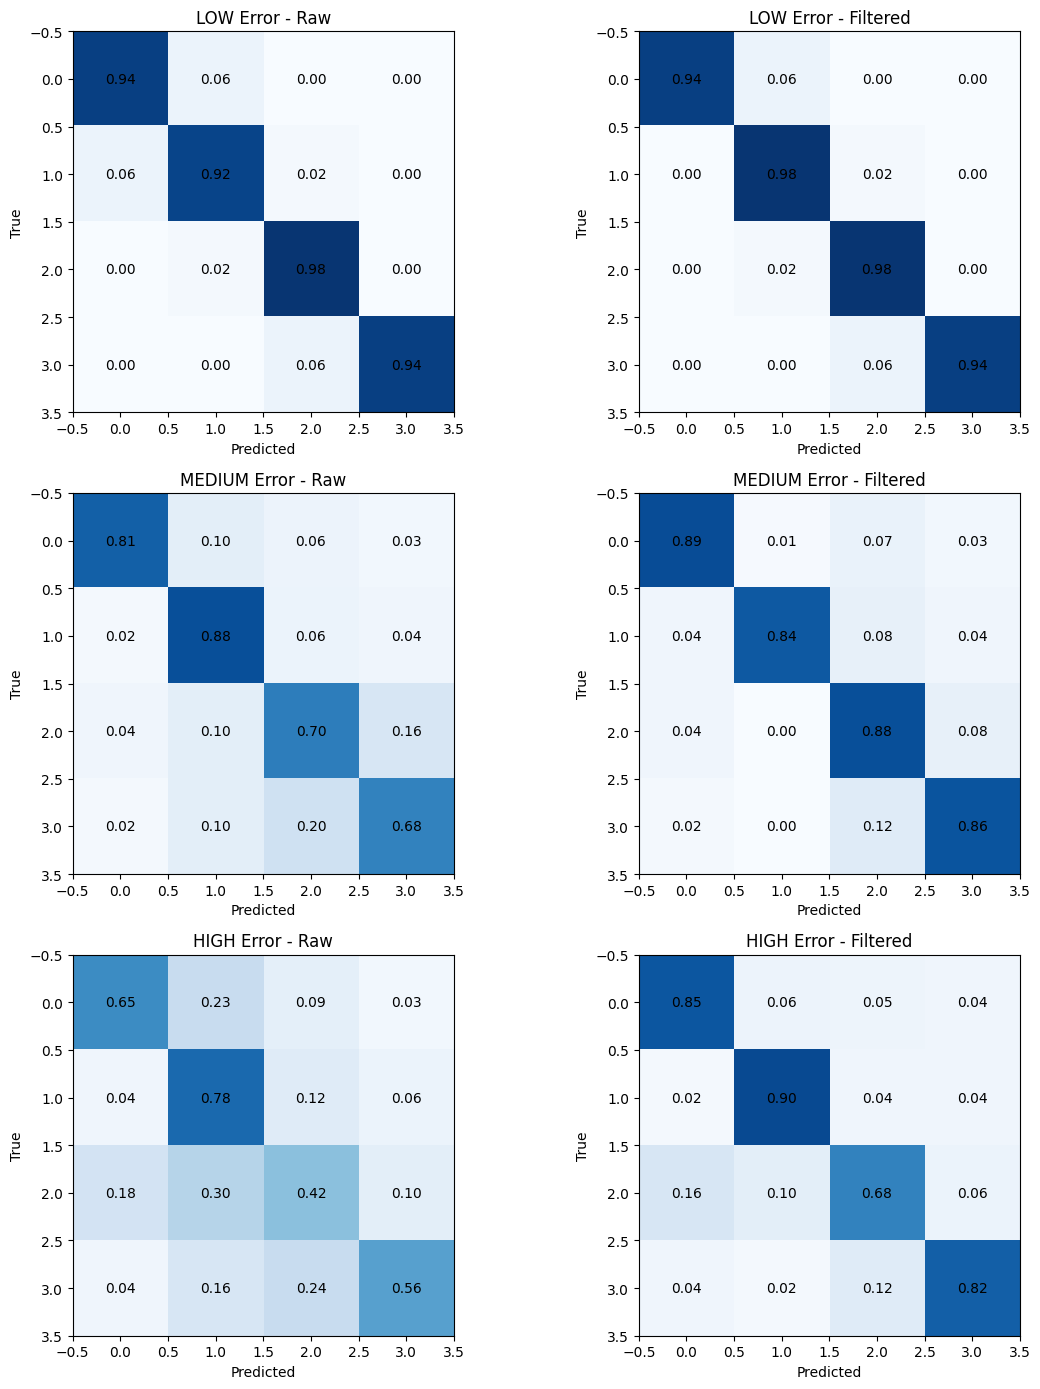

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(12, 14))

stickiness = 0.85  # Use middle stickiness value

for idx, error_level in enumerate(error_levels.keys()):
    noisy = noisy_sequences[error_level]
    filtered = filtered_sequences[error_level][stickiness]

    # Raw confusion matrix
    cm_raw = confusion_matrix(ground_truth, noisy, normalize='true')
    im1 = axes[idx, 0].imshow(cm_raw, cmap='Blues', vmin=0, vmax=1)
    axes[idx, 0].set_title(f'{error_level.upper()} Error - Raw')
    axes[idx, 0].set_xlabel('Predicted')
    axes[idx, 0].set_ylabel('True')

    # Add text annotations
    for i in range(n_classes):
        for j in range(n_classes):
            axes[idx, 0].text(j, i, f'{cm_raw[i, j]:.2f}',
                             ha='center', va='center', fontsize=10)

    # Filtered confusion matrix
    cm_filtered = confusion_matrix(ground_truth, filtered, normalize='true')
    im2 = axes[idx, 1].imshow(cm_filtered, cmap='Blues', vmin=0, vmax=1)
    axes[idx, 1].set_title(f'{error_level.upper()} Error - Filtered')
    axes[idx, 1].set_xlabel('Predicted')
    axes[idx, 1].set_ylabel('True')

    for i in range(n_classes):
        for j in range(n_classes):
            axes[idx, 1].text(j, i, f'{cm_filtered[i, j]:.2f}',
                             ha='center', va='center', fontsize=10)

plt.tight_layout();

## 11. Detailed Classification Reports

In [13]:
stickiness = 0.85

for error_level in error_levels.keys():
    noisy = noisy_sequences[error_level]
    filtered = filtered_sequences[error_level][stickiness]

    print("\n" + "="*80)
    print(f"{error_level.upper()} ERROR LEVEL - Classification Reports")
    print("="*80)

    print(f"\n--- RAW (NOISY) ---")
    print(classification_report(ground_truth, noisy, target_names=[f'Class {i}' for i in range(n_classes)]))

    print(f"\n--- FILTERED (stickiness={stickiness}) ---")
    print(classification_report(ground_truth, filtered, target_names=[f'Class {i}' for i in range(n_classes)]))


LOW ERROR LEVEL - Classification Reports

--- RAW (NOISY) ---
              precision    recall  f1-score   support

     Class 0       0.98      0.94      0.96       200
     Class 1       0.78      0.92      0.84        50
     Class 2       0.92      0.98      0.95        50
     Class 3       1.00      0.94      0.97        50

    accuracy                           0.94       350
   macro avg       0.92      0.94      0.93       350
weighted avg       0.95      0.94      0.94       350


--- FILTERED (stickiness=0.85) ---
              precision    recall  f1-score   support

     Class 0       1.00      0.94      0.97       200
     Class 1       0.79      0.98      0.88        50
     Class 2       0.92      0.98      0.95        50
     Class 3       1.00      0.94      0.97        50

    accuracy                           0.95       350
   macro avg       0.93      0.96      0.94       350
weighted avg       0.96      0.95      0.95       350


MEDIUM ERROR LEVEL - Classific

## 12. Summary Visualization

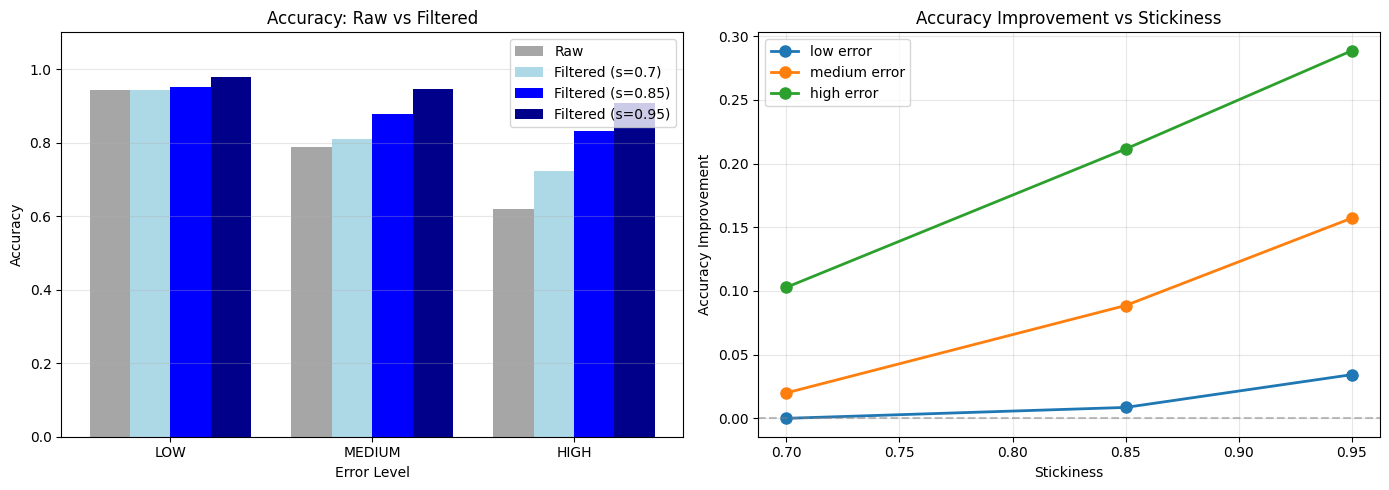

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison across error levels
x = np.arange(len(error_levels))
width = 0.2

raw_accs = [accuracy_score(ground_truth, noisy_sequences[e]) for e in error_levels.keys()]

bars1 = axes[0].bar(x - 1.5*width, raw_accs, width, label='Raw', color='gray', alpha=0.7)

colors = ['lightblue', 'blue', 'darkblue']
for i, stickiness in enumerate(stickiness_values):
    filtered_accs = [accuracy_score(ground_truth, filtered_sequences[e][stickiness])
                     for e in error_levels.keys()]
    axes[0].bar(x + (i-0.5)*width, filtered_accs, width,
                label=f'Filtered (s={stickiness})', color=colors[i])

axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Error Level')
axes[0].set_title('Accuracy: Raw vs Filtered')
axes[0].set_xticks(x)
axes[0].set_xticklabels([e.upper() for e in error_levels.keys()])
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Improvement by stickiness for each error level
for i, error_level in enumerate(error_levels.keys()):
    raw_acc = accuracy_score(ground_truth, noisy_sequences[error_level])
    improvements = [(accuracy_score(ground_truth, filtered_sequences[error_level][s]) - raw_acc)
                    for s in stickiness_values]
    axes[1].plot(stickiness_values, improvements, 'o-',
                 label=f'{error_level} error', linewidth=2, markersize=8)

axes[1].set_xlabel('Stickiness')
axes[1].set_ylabel('Accuracy Improvement')
axes[1].set_title('Accuracy Improvement vs Stickiness')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout();

## 13. Key Findings

### Summary

In [15]:
print("KEY FINDINGS")
print("="*60)
print()
print("1. ASYMMETRIC CONFUSION PATTERNS:")
print("   - Class 1 acts as an 'attractor' - other classes often")
print("     get misclassified as Class 1")
print("   - Class 2 has the worst accuracy in high-error conditions")
print("   - Confusion is not symmetric: P(0→1) ≠ P(1→0)")
print()
print("2. FILTERING EFFECTIVENESS:")
print("   - The HMM filter improves accuracy even with asymmetric errors")
print("   - Improvement is most dramatic for high-error scenarios")
print()

# Find best stickiness for each error level
print("3. OPTIMAL STICKINESS VALUES:")
for error_level in error_levels.keys():
    best_stickiness = max(stickiness_values,
                          key=lambda s: accuracy_score(ground_truth,
                                                       filtered_sequences[error_level][s]))
    best_acc = accuracy_score(ground_truth, filtered_sequences[error_level][best_stickiness])
    raw_acc = accuracy_score(ground_truth, noisy_sequences[error_level])
    print(f"   {error_level.upper()}: Best stickiness = {best_stickiness} "
          f"(acc: {raw_acc:.3f} → {best_acc:.3f})")

print()
print("4. TRADE-OFFS:")
print("   - Higher stickiness: Better noise rejection, slower response to changes")
print("   - Lower stickiness: Faster response to changes, less noise rejection")
print("   - The filter uses knowledge of the asymmetric confusion matrix")
print("     to correctly weight evidence from observations")

KEY FINDINGS

1. ASYMMETRIC CONFUSION PATTERNS:
   - Class 1 acts as an 'attractor' - other classes often
     get misclassified as Class 1
   - Class 2 has the worst accuracy in high-error conditions
   - Confusion is not symmetric: P(0→1) ≠ P(1→0)

2. FILTERING EFFECTIVENESS:
   - The HMM filter improves accuracy even with asymmetric errors
   - Improvement is most dramatic for high-error scenarios

3. OPTIMAL STICKINESS VALUES:
   LOW: Best stickiness = 0.95 (acc: 0.943 → 0.977)
   MEDIUM: Best stickiness = 0.95 (acc: 0.789 → 0.946)
   HIGH: Best stickiness = 0.95 (acc: 0.620 → 0.909)

4. TRADE-OFFS:
   - Higher stickiness: Better noise rejection, slower response to changes
   - Lower stickiness: Faster response to changes, less noise rejection
   - The filter uses knowledge of the asymmetric confusion matrix
     to correctly weight evidence from observations
